In [1]:
pip install neo4j-graphrag

  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
  Attempting uninstall: neo4j
    Found existing installation: neo4j 6.0.2
    Uninstalling neo4j-6.0.2:
      Successfully uninstalled neo4j-6.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.10.0
    Uninstalling fsspec-2025.10.0:
      Successfully uninstalled fsspec-2025.10.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install langchain-litellm

  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached jsonpatch-1.33-py2.py3-none-any.whl (12 kB)
Using cached jsonpointer-3.0.0-py2.py3-none-any.whl (7.6 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install langgraph

  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-litellm 0.3.0 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 1.0.3 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import os
import json
from pprint import pprint
from typing import TypedDict, List, Optional
from dotenv import load_dotenv

import litellm
from neo4j import GraphDatabase, Driver
from langchain_litellm import ChatLiteLLM
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

# Neo4j GraphRAG library
from neo4j_graphrag.retrievers import VectorRetriever
#from neo4j_graphrag.types import VectorIndexConfig

# Embedding model (synchronized with ingestor)
from sentence_transformers import SentenceTransformer

In [13]:
# --- Helper for Embeddings ---
# Synchronized with ingestor: Uses sentence-transformers/all-mpnet-base-v2 for 768-dim vectors
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def get_embedding(text: str) -> List[float]:
    """
    Generates 768-dimensional embeddings using the same model as ingestion.
    Embeddings are L2-normalized for cosine similarity.
    """
    embeddings = embedding_model.encode(text)
    return embeddings.tolist()  # Returns list for Neo4j compatibility

In [14]:
# === 1. Load Config & Set Up Clients ===
load_dotenv()

# --- LiteLLM Configuration (Fixed Deprecation) ---
os.environ['LITELLM_LOG'] = 'INFO'  # Replaces litellm.set_verbose
litellm.api_key = os.getenv("GROQ_API_KEY")
litellm.model_list = [
    {
        "model_name": "groq/llama-3.3-70b-versatile",
        "litellm_params": {"model": "groq/llama-3.3-70b-versatile", "api_key": os.getenv("GROQ_API_KEY")}
    }
]

# --- LangChain/LangGraph LLM ---
llm = ChatLiteLLM(model="groq/llama-3.3-70b-versatile")

# --- Neo4j Connection ---
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE", "neo4j")

try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    driver.verify_connectivity()
    print("Neo4j connection successful.")
    
    # Verify vector indexes (GraphRAG best practice)
    with driver.session(database=NEO4J_DATABASE) as session:
        indexes = session.run("SHOW VECTOR INDEXES YIELD name, state").data()
        for idx in indexes:
            print(f"Vector Index '{idx['name']}': {idx['state']}")
        if not any(idx['name'] == 'fact_embeddings' for idx in indexes):
            raise ValueError("Required 'fact_embeddings' index not found. Run ingestor first.")
            
except Exception as e:
    print(f"Failed to connect to Neo4j or verify indexes: {e}")

Neo4j connection successful.
Vector Index 'fact_embeddings': ONLINE
Vector Index 'section_embeddings': ONLINE


In [15]:
# === 2. LangGraph State Definition ===

# Evolved from the state in your retriever.ipynb
class RetrievalState(TypedDict):
    question: str
    original_question: str
    current_nodes: List[str]  # Facts or sections found in the last step
    notebook: List[str]       # The full "context" of all facts found so far
    traversal_count: int
    traversal_limit: int

In [ ]:
# === 3. LangGraph Agent Nodes ===
def initial_discovery(state: RetrievalState) -> RetrievalState:
    """
    GraphRAG Entrypoint: Uses vector search (via neo4j-graphrag) to find initial nodes.
    Includes full-text fallback.
    """
    print("--- Node: initial_discovery ---")
    question = state['question']
    question_embedding = get_embedding(question)
    
    current_nodes = []
    with driver.session(database=NEO4J_DATABASE) as session:  # Session for full-text fallback
        # 1. Primary: GraphRAG Vector Search on FactNodes (using library)
        try:
            # Initialize retriever with driver (not session), return_properties for fact access
            retriever = VectorRetriever(
                driver=driver,
                index_name="fact_embeddings",
                return_properties=["fact"],  # Fetch specific property
                neo4j_database=NEO4J_DATABASE
            )
            # Search with top_k; filter by score >= 0.7 manually
            results = retriever.search(query_vector=question_embedding, top_k=5)
            filtered_results = []
            for r in results.items:
                if r.metadata.get("score", 0) >= 0.7:
                    filtered_results.append((r.content, r.metadata["score"]))
            current_nodes = [item[0] for item in filtered_results]
            scores = [r.metadata.get("score", 0) for r in results.items]
            print(f"  Vector hits (facts): {len(filtered_results)} (all scores: {scores}, min filtered: {min([item[1] for item in filtered_results]) if filtered_results else 'N/A'})")
        except Exception as e:
            print(f"  Error in fact vector search: {e}")

        if not current_nodes:
            # 1b. Vector Fallback: Search SectionChunks
            try:
                print("  No fact hits, trying section chunks...")
                retriever = VectorRetriever(
                    driver=driver,
                    index_name="section_embeddings",
                    return_properties=["text"],
                    neo4j_database=NEO4J_DATABASE
                )
                results = retriever.search(query_vector=question_embedding, top_k=5)
                filtered_results = []
                for r in results.items:
                    if r.metadata.get("score", 0) >= 0.7:
                        filtered_results.append((r.content, r.metadata["score"]))
                current_nodes = [item[0] for item in filtered_results]
                scores = [r.metadata.get("score", 0) for r in results.items]
                print(f"  Vector hits (chunks): {len(filtered_results)} (all scores: {scores}, min filtered: {min([item[1] for item in filtered_results]) if filtered_results else 'N/A'})")
            except Exception as e:
                print(f"  Error in chunk vector search: {e}")

        if not current_nodes:
            # 2. Fallback: Full-Text Search (raw Cypher)
            print("  No vector hits, using full-text fallback...")
            fulltext_hits = session.run(
                """
                CALL db.index.fulltext.queryNodes('text_index', $question) 
                YIELD node, score
                RETURN COALESCE(node.fact, node.text) AS text, score
                ORDER BY score DESC
                LIMIT 5
                """,
                question=question
            ).data()
            current_nodes = [r['text'] for r in fulltext_hits]
            print(f"  Full-text hits: {len(current_nodes)}")
                
    state['current_nodes'] = current_nodes
    state['notebook'].extend(["Initial relevant facts:"] + current_nodes)
    return state

def hop_analyzer(state: RetrievalState) -> RetrievalState:
    """
    Agentic Traversal: Performs an undirected hop to find new, related facts.
    """
    print("--- Node: hop_analyzer ---")
    # This is the "looping fallback" we discussed
    if state['traversal_count'] >= state['traversal_limit']:
        print("  Traversal limit reached. Stopping hops.")
        state['current_nodes'] = []
        return state

    state['traversal_count'] += 1
    
    with driver.session(database=NEO4J_DATABASE) as session:
        # Undirected hop: Find facts that share an entity with our current facts
        # but are NOT already in our notebook.
        new_facts = session.run(
            """
            MATCH (f:FactNode)-[:HAS_ENTITY]->(e:EntityNode)<-[:HAS_ENTITY]-(neighbor_fact:FactNode)
            WHERE f.fact IN $current_facts AND NOT neighbor_fact.fact IN $notebook_facts
            RETURN DISTINCT neighbor_fact.fact AS new_fact
            LIMIT 10
            """,
            current_facts=state['current_nodes'],
            notebook_facts=state['notebook']
        ).data()
        
        found_facts = [r['new_fact'] for r in new_facts]
        state['current_nodes'] = found_facts
        
        if found_facts:
            state['notebook'].extend(["Found related facts:"] + found_facts)
            print(f"  Found {len(found_facts)} new related facts.")
        else:
            print("  No new related facts found.")
            
    return state

def context_manager(state: RetrievalState) -> RetrievalState:
    """
    Intelligent Context Manager: Summarizes the notebook if it gets too large.
    """
    print("--- Node: context_manager ---")
    current_context_length = len(json.dumps(state['notebook']))
    
    # Example trigger: 4000 characters
    if current_context_length > 4000:
        print(f"  Context length ({current_context_length}) > 4000. Summarizing...")
        try:
            response = llm.invoke(
                f"Concisely summarize the following facts into a single paragraph: \n\n"
                f"{json.dumps(state['notebook'])}"
            )
            state['notebook'] = ["Context summarized:", response.content]
            print("  Context successfully summarized.")
        except Exception as e:
            print(f"  Error summarizing context: {e}. Pruning instead.")
            # Fallback for summarization: simple pruning
            state['notebook'] = state['notebook'][-10:] # Keep last 10 items
            
    return state

def evaluate_answer(state: RetrievalState) -> RetrievalState:
    """
    Analyzer Node: Decides if the answer is sufficient, needs a deepdive,
    or needs more hops.
    (This is an evolution of your evaluate_answer node)
    """
    print("--- Node: evaluate_answer ---")
    
    # Loop fallback (if analyzer is hit after limit)
    if state['traversal_count'] >= state['traversal_limit']:
        print("  Traversal limit reached. Force-ending.")
        return {"decision": "sufficient"}
    
    # If no new nodes were found on the last hop, we're stuck.
    if not state['current_nodes']:
        print("  No new nodes found. Force-ending.")
        return {"decision": "sufficient"}

    try:
        prompt = f"""
        You are an expert evaluator for a RAG agent.
        Original Question: {state['original_question']}
        
        Current Facts Notebook:
        {json.dumps(state['notebook'], indent=2)}
        
        Based *only* on the facts in the notebook, is the Original Question
        fully and completely answered?
        
        Choose one of the following decisions:
        1. 'sufficient': The answer is complete and no more info is needed.
        2. 'hop_more': The answer is incomplete. We need to find more *related* facts.
        3. 'deepdive': The answer is incomplete and we need a *new line of questioning*
           to find different, specific information.
           
        Respond with a single JSON object: {{"decision": "your_choice"}}
        """
        
        response = llm.invoke(prompt)
        decision_data = json.loads(response.content)
        print(f"  LLM Decision: {decision_data['decision']}")
        return decision_data
    
    except Exception as e:
        print(f"  Error evaluating answer: {e}. Defaulting to 'sufficient'.")
        return {"decision": "sufficient"}

def replan_query(state: RetrievalState) -> RetrievalState:
    """
    Query Modification Node: Creates a new, more specific query for a deepdive.
    """
    print("--- Node: replan_query ---")
    try:
        prompt = f"""
        You are a query replanner.
        Original Question: {state['original_question']}
        Current Context: {json.dumps(state['notebook'], indent=2)}
        
        The current context is not enough. What *new, specific query*
        should we use to find the missing information?
        
        Respond with a single JSON object: {{"new_query": "your_new_query"}}
        """
        
        response = llm.invoke(prompt)
        query_data = json.loads(response.content)
        
        # This is the "new trajectory"
        state['question'] = query_data['new_query']
        state['notebook'].append(f"RE-PLANNING: New query: {query_data['new_query']}")
        state['current_nodes'] = [] # Clear nodes for new discovery
        
        print(f"  New query: {state['question']}")
        
    except Exception as e:
        print(f"  Error replanning query: {e}. Reverting to original.")
        state['question'] = state['original_question']

    return state

def compile_final_answer(state: RetrievalState) -> RetrievalState:
    """
    Calls the LLM one last time to generate a final answer from the notebook.
    """
    print("--- Node: compile_final_answer ---")
    try:
        response = llm.invoke(
            f"Original Question: {state['original_question']}\n\n"
            f"Use *only* the following facts to answer the question:\n"
            f"{json.dumps(state['notebook'], indent=2)}\n\n"
            f"Answer:"
        )
        # We'll add the final answer back into the 'notebook'
        state['notebook'].append(f"Final Answer: {response.content}")
        print(f"  Final Answer: {response.content}")
    except Exception as e:
        print(f"  Error compiling final answer: {e}")
        state['notebook'].append(f"Error compiling final answer: {e}")
        
    return state

In [102]:
# === 4. LangGraph Graph Definition ===

def build_graph():
    workflow = StateGraph(RetrievalState)

    # 1. Add Nodes
    workflow.add_node("initial_discovery", initial_discovery)
    workflow.add_node("hop_analyzer", hop_analyzer)
    workflow.add_node("context_manager", context_manager)
    workflow.add_node("evaluate_answer", evaluate_answer)
    workflow.add_node("replan_query", replan_query)
    workflow.add_node("compile_final_answer", compile_final_answer)

    # 2. Set Entry Point
    workflow.set_entry_point("initial_discovery")

    # 3. Add Edges
    workflow.add_edge("initial_discovery", "hop_analyzer")
    workflow.add_edge("hop_analyzer", "context_manager")
    workflow.add_edge("context_manager", "evaluate_answer")
    
    # 4. Add Conditional Edges (The "Agentic" part)
    workflow.add_conditional_edges(
        "evaluate_answer",
        lambda x: x["decision"],
        {
            "sufficient": "compile_final_answer",
            "hop_more": "hop_analyzer", # Main loop
            "deepdive": "replan_query" # New trajectory
        }
    )
    
    # 5. Add New Trajectory Edge
    workflow.add_edge("replan_query", "initial_discovery")
    
    # 6. Set End Point
    workflow.add_edge("compile_final_answer", END)

    # 7. Compile
    return workflow.compile(checkpointer=MemorySaver())

In [107]:
# === 5. Main Execution Function ===
def main():
    app = build_graph()
    
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    # Define the initial state for the query
    inputs = {
        "question": "What was Tesla's revenue in Q4 2024 and how is Cybertruck production?",
        "original_question": "What was Tesla's revenue in Q4 2024 and how is Cybertruck production?",
        "notebook": [],
        "current_nodes": [],
        "traversal_count": 0,
        "traversal_limit": 3
    }
    
    config = {"configurable": {"thread_id": "1"}}
    
    print("--- Running Agentic Retrieval ---")
    
    # Stream the events
    try:
        for event in app.stream(inputs, config=config, stream_mode="values"):
            print("\n" + "="*40)
            pprint(event)
            print("="*40)
        
        print("--- Run Complete ---")
        final_state = app.get_state(config)
        print(f"Final Notebook:\n{json.dumps(final_state.values['notebook'], indent=2)}")
    
    except Exception as e:
        print(f"An error occurred during the agent run: {e}")
    finally:
        if 'driver' in globals():
            driver.close()
            print("\nNeo4j connection closed.")

In [30]:
# This will run the main agent function
main()

--- Running Agentic Retrieval ---

{'current_nodes': [],
 'notebook': [],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck production?',
 'question': "What was Tesla's revenue in Q4 2024 and how is Cybertruck "
             'production?',
 'traversal_count': 0,
 'traversal_limit': 3}
--- Node: initial_discovery ---


C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\1791045164.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:  # Session for full-text fallback


  Error in fact vector search: 'tuple' object has no attribute 'metadata'
  No fact hits, trying section chunks...
  Error in chunk vector search: 'tuple' object has no attribute 'metadata'
  No vector hits, using full-text fallback...
  Full-text hits: 5

{'current_nodes': ['Net income for Q4 2024 was $2.48 billion.',
                   '\n'
                   '    Tesla, Inc. (TSLA) reported its fourth-quarter 2024 '
                   'earnings on January 25, 2025.\n'
                   '    The company announced total revenue of $25.17 billion, '
                   'missing analyst expectations.\n'
                   '    Automotive revenue was $21.56 billion. The Cybertruck '
                   'production ramp-up\n'
                   '    is proceeding, with 1,000 units built in a single '
                   'week.',
                   'Automotive revenue was $21.56 billion.',
                   'The Cybertruck production ramp-up built 1,000 units in a '
                   'sing

C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\1791045164.py:144: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:


  Found 1 new related facts.

{'current_nodes': ['Tesla, Inc. reported its fourth-quarter 2024 earnings on '
                   'January 25, 2025.'],
 'notebook': ['Initial relevant facts:',
              'Net income for Q4 2024 was $2.48 billion.',
              '\n'
              '    Tesla, Inc. (TSLA) reported its fourth-quarter 2024 '
              'earnings on January 25, 2025.\n'
              '    The company announced total revenue of $25.17 billion, '
              'missing analyst expectations.\n'
              '    Automotive revenue was $21.56 billion. The Cybertruck '
              'production ramp-up\n'
              '    is proceeding, with 1,000 units built in a single week.',
              'Automotive revenue was $21.56 billion.',
              'The Cybertruck production ramp-up built 1,000 units in a single '
              'week.',
              'Tesla delivered 1.81 million vehicles in 2024.',
              'Found related facts:',
              'Tesla, Inc. reported

In [34]:
main()

--- Running Agentic Retrieval ---

{'current_nodes': [],
 'notebook': [],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck production?',
 'question': "What was Tesla's revenue in Q4 2024 and how is Cybertruck "
             'production?',
 'traversal_count': 0,
 'traversal_limit': 3}
--- Node: initial_discovery ---
facts :items=[RetrieverResultItem(content="{'fact': 'Tesla delivered 1.81 million vehicles in 2024.'}", metadata={'score': 0.8203999996185303, 'nodeLabels': ['FactNode'], 'id': '4:9a783a02-7c84-42af-8a16-a6c5fb02c6b1:18'}), RetrieverResultItem(content="{'fact': 'Tesla, Inc. reported its fourth-quarter 2024 earnings on January 25, 2025.'}", metadata={'score': 0.799100399017334, 'nodeLabels': ['FactNode'], 'id': '4:9a783a02-7c84-42af-8a16-a6c5fb02c6b1:3'}), RetrieverResultItem(content="{'fact': 'Net income for Q4 2024 was $2.48 billion.'}", metadata={'score': 0.7752914428710938, 'nodeLabels': ['FactNode'], 'id': '4:9a783

C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\3307909319.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:  # Session for full-text fallback
C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\3307909319.py:146: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:


  LLM Decision: sufficient
--- Node: compile_final_answer ---
  Final Answer: Tesla's revenue in Q4 2024 was $25.17 billion, with automotive revenue being $21.56 billion. As for Cybertruck production, the ramp-up is proceeding, with 1,000 units built in a single week.

{'current_nodes': ['Tesla, Inc. reported its fourth-quarter 2024 earnings on '
                   'January 25, 2025.'],
 'notebook': ['Initial relevant facts:',
              'Net income for Q4 2024 was $2.48 billion.',
              '\n'
              '    Tesla, Inc. (TSLA) reported its fourth-quarter 2024 '
              'earnings on January 25, 2025.\n'
              '    The company announced total revenue of $25.17 billion, '
              'missing analyst expectations.\n'
              '    Automotive revenue was $21.56 billion. The Cybertruck '
              'production ramp-up\n'
              '    is proceeding, with 1,000 units built in a single week.',
              'Automotive revenue was $21.56 billion.',
 

In [104]:
main()

--- Running Agentic Retrieval ---

{'current_nodes': [],
 'notebook': [],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck production?',
 'question': "What was Tesla's revenue in Q4 2024 and how is Cybertruck "
             'production?',
 'traversal_count': 0,
 'traversal_limit': 3}
--- Node: initial_discovery ---
  Vector hits (facts): 5 (all scores: [0.8203999996185303, 0.799100399017334, 0.7752914428710938, 0.7536176443099976, 0.7514336109161377], min filtered: 0.7514336109161377)

{'current_nodes': ["{'fact': 'Tesla delivered 1.81 million vehicles in 2024.'}",
                   "{'fact': 'Tesla, Inc. reported its fourth-quarter 2024 "
                   "earnings on January 25, 2025.'}",
                   "{'fact': 'Net income for Q4 2024 was $2.48 billion.'}",
                   "{'fact': 'Tesla warned of a lower volume growth rate in "
                   "2025.'}",
                   "{'fact': 'The company announced tota

C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\2487377257.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:  # Session for full-text fallback
C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\2487377257.py:150: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:


  Final Answer: Based on the provided facts, Tesla's revenue in Q4 2024 was $25.17 billion. However, there is no information available about Cybertruck production.

{'current_nodes': [],
 'notebook': ['Initial relevant facts:',
              "{'fact': 'Tesla delivered 1.81 million vehicles in 2024.'}",
              "{'fact': 'Tesla, Inc. reported its fourth-quarter 2024 earnings "
              "on January 25, 2025.'}",
              "{'fact': 'Net income for Q4 2024 was $2.48 billion.'}",
              "{'fact': 'Tesla warned of a lower volume growth rate in 2025.'}",
              "{'fact': 'The company announced total revenue of $25.17 "
              "billion.'}",
              "Final Answer: Based on the provided facts, Tesla's revenue in "
              'Q4 2024 was $25.17 billion. However, there is no information '
              'available about Cybertruck production.'],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck pr

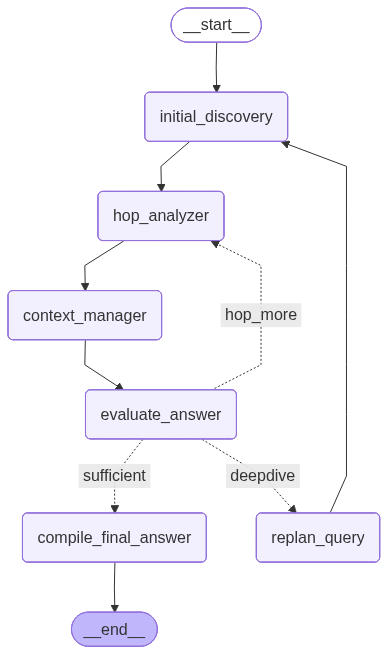

--- Running Agentic Retrieval ---

{'current_nodes': [],
 'notebook': [],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck production?',
 'question': "What was Tesla's revenue in Q4 2024 and how is Cybertruck "
             'production?',
 'traversal_count': 0,
 'traversal_limit': 3}
--- Node: initial_discovery ---
  Vector hits (facts): 5 (all scores: [0.8203999996185303, 0.799100399017334, 0.7752914428710938, 0.7536176443099976, 0.7514336109161377], min filtered: 0.7514336109161377)

{'current_nodes': ["{'fact': 'Tesla delivered 1.81 million vehicles in 2024.'}",
                   "{'fact': 'Tesla, Inc. reported its fourth-quarter 2024 "
                   "earnings on January 25, 2025.'}",
                   "{'fact': 'Net income for Q4 2024 was $2.48 billion.'}",
                   "{'fact': 'Tesla warned of a lower volume growth rate in "
                   "2025.'}",
                   "{'fact': 'The company announced tota

C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\2487377257.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:  # Session for full-text fallback
C:\Users\srdro\AppData\Local\Temp\ipykernel_15260\2487377257.py:150: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=NEO4J_DATABASE) as session:


  Final Answer: Tesla's revenue in Q4 2024 was $25.17 billion. However, the provided facts do not include any information about Cybertruck production.

{'current_nodes': [],
 'notebook': ['Initial relevant facts:',
              "{'fact': 'Tesla delivered 1.81 million vehicles in 2024.'}",
              "{'fact': 'Tesla, Inc. reported its fourth-quarter 2024 earnings "
              "on January 25, 2025.'}",
              "{'fact': 'Net income for Q4 2024 was $2.48 billion.'}",
              "{'fact': 'Tesla warned of a lower volume growth rate in 2025.'}",
              "{'fact': 'The company announced total revenue of $25.17 "
              "billion.'}",
              "Final Answer: Tesla's revenue in Q4 2024 was $25.17 billion. "
              'However, the provided facts do not include any information '
              'about Cybertruck production.'],
 'original_question': "What was Tesla's revenue in Q4 2024 and how is "
                      'Cybertruck production?',
 'question': "

In [108]:
main()